In [1]:
import matplotlib.pyplot as plt
import numpy as np 
import scipy
from scipy.linalg import hadamard
import scipy.signal
import pylab

# Set up helper functions

In [6]:
def set_walsh(N, n, stepperiod, verify=False):
        """
        N: order of walsh matrix
        n: walsh index to give this stream
        stepperiod: period (2^?), in multiples of self.periodbase FPGA clocks,
                of shortest walsh step. I.e., 2**13 * 2**self.baseperiod * N
                = period of complete cycle in FPGA clocks.
        """
        depth = 2**12
        N_round = int(2**(np.ceil(np.log2(N))))
        walsh_matrix = hadamard(N_round)
        # reformat so 1 means multiply by -1, and 0 means multiply by 1
        walsh_matrix[walsh_matrix == 1]  = 1
        walsh_matrix[walsh_matrix == -1] = -1
        walsh_func = walsh_matrix[n] # a vector of length N_round
        walsh_func_stretch = walsh_func.repeat(2**stepperiod) # a vector of length N_round * 2*step_period
        # The counter in the FPGA cycles through <depth> ram addresses, so repeat
        # the sequence. Since N_round and 2**stepperiod are always powers of 2,
        # this is always an integer number of cycles
        vec = np.array(walsh_func_stretch.tolist() * int(depth/ 2**stepperiod / N_round))
        return vec
    
def set_walsh_sim(N, n, stepperiod, verify=False):
        """
        N: order of walsh matrix
        n: walsh index to give this stream
        stepperiod: period (2^?), in multiples of self.periodbase FPGA clocks,
                of shortest walsh step. I.e., 2**13 * 2**self.baseperiod * N
                = period of complete cycle in FPGA clocks.
        """
        depth = 2**12
        N_round = int(2**(np.ceil(np.log2(N))))
        walsh_matrix = hadamard(N_round)
        # reformat so 1 means multiply by -1, and 0 means multiply by 1
        walsh_matrix[walsh_matrix == 1]  = 1
        walsh_matrix[walsh_matrix == -1] = -1
        walsh_func = walsh_matrix[n] # a vector of length N_round
        walsh_func_stretch = walsh_func.repeat(2**stepperiod) # a vector of length N_round * 2*step_period
        return walsh_func_stretch

def db(x):
    """ Convert linear value to dB value """
    return 10*np.log10(x)

def pfb_fir_frontend(x, win_coeffs, M, P):
    W = int(x.shape[0] / M / P)
    x_p = x.reshape((W*M, P)).T
    h_p = win_coeffs.reshape((M, P)).T
    x_summed = np.zeros((P, M * W - M))
    for t in range(0, M*W-M):
        x_weighted = x_p[:, t:t+M] * h_p
        x_summed[:, t] = x_weighted.sum(axis=1)
    return x_summed.T

def generate_win_coeffs(M, P, window_fn="hamming"):
    win_coeffs = scipy.signal.get_window(window_fn, M*P)
    sinc       = scipy.signal.firwin(M * P, cutoff=1.0/P, window="rectangular")
    win_coeffs *= sinc
    return win_coeffs

def fft(x_p, P, axis=1):
    return np.fft.rfft(x_p, P, axis=axis)

def pfb_filterbank(x, win_coeffs, M, P):
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    return x_pfb

def pfb_spectrometer(x, n_taps, n_chan, n_int, window_fn="hamming"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    x_psd = np.abs(x_pfb)**2
    
    # Trim array so we can do time integration
    x_psd = x_psd[:np.round(x_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    x_psd = x_psd.reshape(x_psd.shape[0]//n_int, n_int, x_psd.shape[1])
    x_psd = x_psd.mean(axis=1)
    
    return x_psd

def pfb_correlator(x, y, n_taps, n_chan, n_int, window_fn="blackman-harris"):
    M = n_taps
    P = n_chan
    
    # Generate window coefficients
    win_coeffs = generate_win_coeffs(M, P, window_fn)

    # Apply frontend, take FFT, then take power (i.e. square)
    x_fir = pfb_fir_frontend(x, win_coeffs, M, P)
    x_pfb = fft(x_fir, P)
    y_fir = pfb_fir_frontend(y, win_coeffs, M, P)
    y_pfb = fft(y_fir, P)
    corr_psd = x_pfb*y_pfb.conj()
    
    
    # Trim array so we can do time integration
    corr_psd = corr_psd[:np.round(corr_psd.shape[0]//n_int)*n_int]
    
    # Integrate over time, by reshaping and summing over axis (efficient)
    corr_psd = corr_psd.reshape(corr_psd.shape[0]//n_int, n_int, corr_psd.shape[1])
    corr_psd = corr_psd.mean(axis=1)
    
    return corr_psd

# Generate Walsh Patterns 

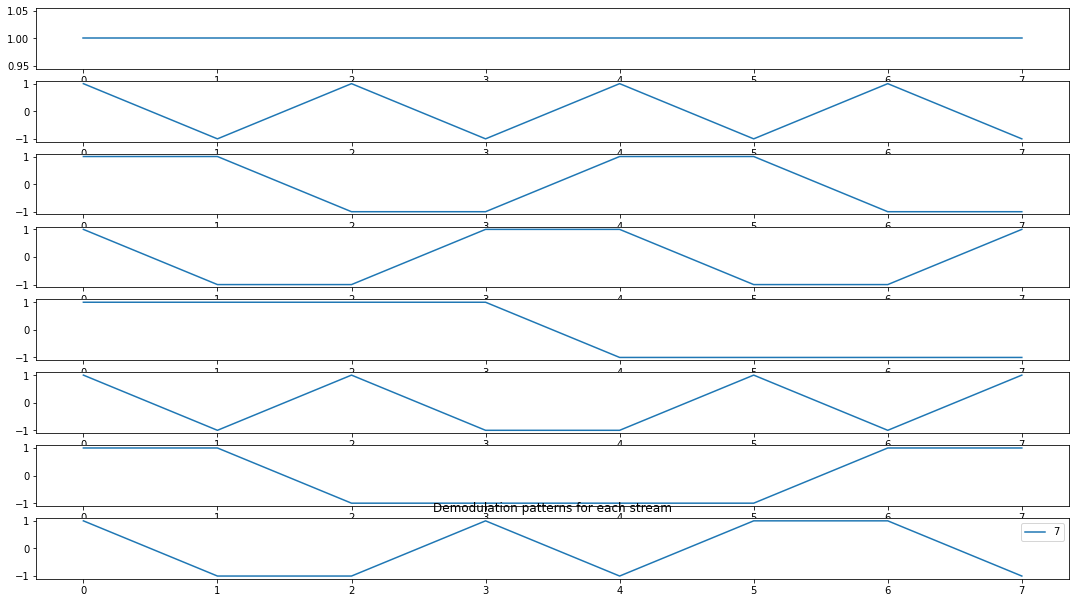

In [7]:
#Generate walsh patterns of a length 8, which could be used for 8 seperate time streams
fig,ax = plt.subplots(8,1)
fig.set_size_inches(18.5, 10.5)
for i in range(8):
    ax[i].plot(set_walsh_sim(8,i,0), label=i)
plt.title('Demodulation patterns for each stream')
plt.legend()
plt.show()

In [8]:
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 1000       # Number of windows of length M*P in input time stream
n_int = 2          # Number of time integrations on output data

# Generate a test data steam that is the appropriate length for the FFT/PFB windowing 
samples = np.arange(M*P*W)
#The "noise" 
noise   = np.random.normal(loc=0, scale=0.1, size=M*P*W) 
freq = 1
freq2 = .5
amp  = 0.2
#The CW signal is our science signal
cw_signal2 = amp * np.sin(samples * freq2)

#The CW signal is our interferer
cw_signal = amp * np.sin(samples * freq)
data = noise + cw_signal + cw_signal2 

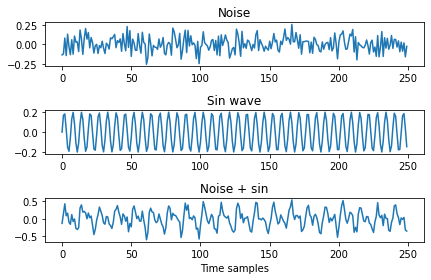

In [9]:
plt.subplot(3,1,1)
plt.title("Noise")
plt.plot(noise[:250])
plt.subplot(3,1,2)
plt.title("Sin wave")
plt.plot(cw_signal[:250])
plt.subplot(3,1,3)
plt.title("Noise + sin")
plt.plot(data[:250])
plt.xlabel("Time samples")
plt.tight_layout()
plt.show()

n_taps: 4
n_branches: 1024
Input signal shape: 4194304
Output data shape: (4092, 513)


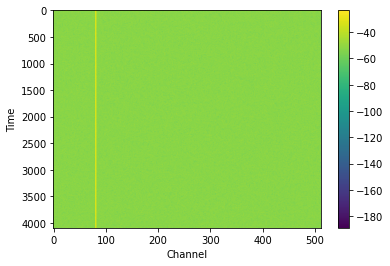

In [28]:
#plot incoming signal as a waterfall 
X_psd = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=1, window_fn="hamming")
print("n_taps: %i" % M)
print("n_branches: %i" % P)
print("Input signal shape: %i" % data.shape)
print("Output data shape: %s" % str(X_psd.shape))
plt.imshow(db(X_psd), cmap='viridis', aspect='auto')
plt.colorbar()
plt.xlabel("Channel")
plt.ylabel("Time")
plt.show()

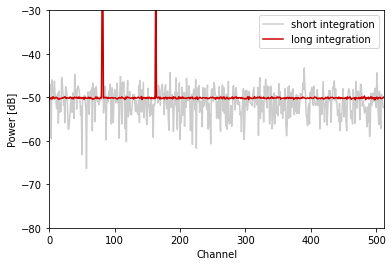

In [11]:
X_psd2 = pfb_spectrometer(data, n_taps=M, n_chan=P, n_int=1000, window_fn="hamming")

plt.plot(db(X_psd[0]), c='#cccccc', label='short integration')
plt.plot(db(X_psd2[1]), c='#cc0000', label='long integration')
plt.ylim(-80, -30)
plt.xlim(0, P/2)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.legend()
plt.show()

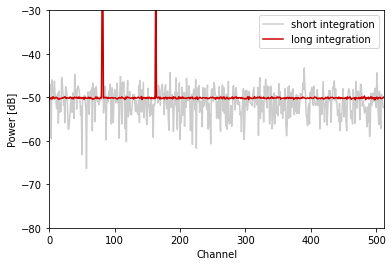

In [12]:
X_psd2 = pfb_correlator(data, data, n_taps=M, n_chan=P, n_int=1000, window_fn="hamming")

plt.plot(db(X_psd[0]), c='#cccccc', label='short integration')
plt.plot(db(np.abs(X_psd2[1])), c='#cc0000', label='long integration')
plt.ylim(-80, -30)
plt.xlim(0, P/2)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.legend()
plt.show()

In [13]:
M     = 4          # Number of taps
P     = 1024       # Number of 'branches', also fft length
W     = 1024       # Number of windows of length M*P in input time stream
n_int = 1024*3       # Number of time integrations on output data

# Generate a longer test signal 
samples = np.arange(M*P*W)
noise   = np.random.normal(loc=0, scale=0.1, size=M*P*W) 
freq = 1
amp  = 0.2
cw_signal = amp * np.sin(samples * freq)
cw_signal2 = amp * np.sin(samples * freq2)
data = noise + cw_signal2
period_base = len(samples)//8

In [14]:
#extend the number of samples for the walsh function to match the signal length 
n= 0
n2 = period_base
walsh0 = set_walsh_sim(8,1,0)
walsh0extended = np.zeros(len(samples))
for i in range(len(walsh0)):
    extended = np.array(walsh0[i].repeat(period_base))
    walsh0extended[n:n2] = extended
    n += period_base
    n2 += period_base

In [15]:
n = 0
n2 = period_base
walsh1 = set_walsh_sim(8,2,0)
walsh1extended = np.zeros(len(samples))
for i in range(len(walsh1)):
    extended = np.array(walsh1[i].repeat(period_base))
    walsh1extended[n:n2] = extended
    n += period_base
    n2 += period_base

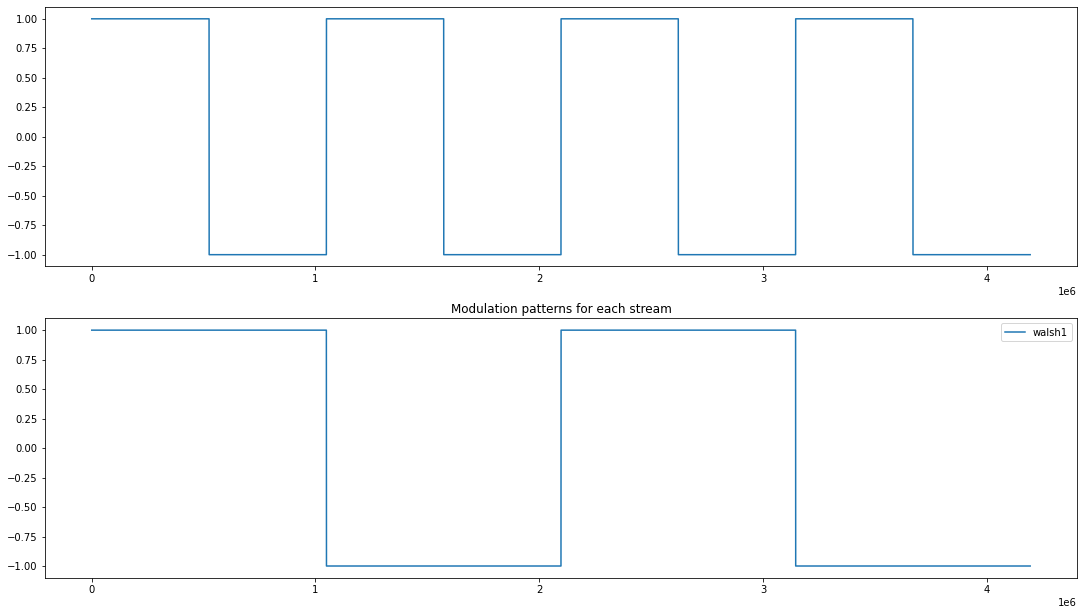

In [16]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].plot(walsh0extended, label='walsh0')
ax[1].plot(walsh1extended, label='walsh1')
#ax[i].set_xlim(0,10)
plt.title('Modulation patterns for each stream')
plt.legend()
plt.show()

In [17]:
modulated0 = np.zeros(len(walsh0extended))
modulated1 = np.zeros(len(walsh1extended))
for i in range(len(walsh0extended)):
    if walsh0extended[i] == 1:
        modulated0[i] = data[i]
    if walsh0extended[i] == -1:
        modulated0[i] = -data[i]

for i in range(len(walsh1extended)):
    if walsh1extended[i] == 1:
        modulated1[i] = data[i]
    if walsh1extended[i] == -1:
        modulated1[i] = -data[i]

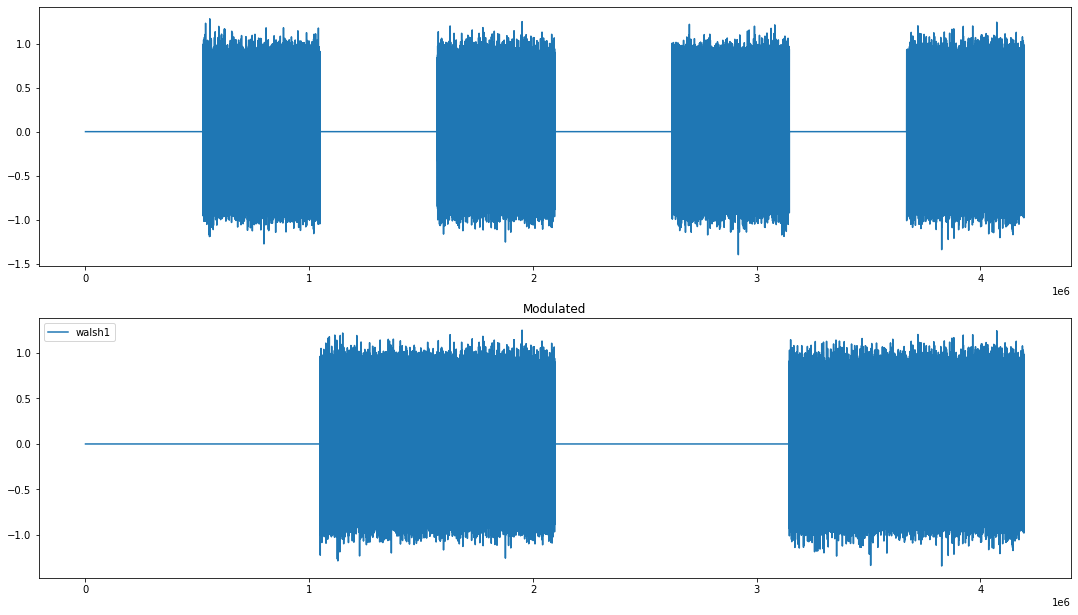

In [18]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].plot(modulated0-data, label='walsh0')
ax[1].plot(modulated1-data, label='walsh1')
#ax[i].set_xlim(0,10)
plt.title('Modulated')
plt.legend()
plt.show()

In [27]:
modulated0 = modulated0 + cw_signal
modulated1 = modulated1 + cw_signal

In [21]:
demodulated0 = np.zeros(len(walsh0extended))
demodulated1 = np.zeros(len(walsh1extended))
for i in range(len(walsh0extended)):
    if walsh0extended[i] == 1:
        demodulated0[i] = modulated0[i]
    if walsh0extended[i] == -1:
        demodulated0[i] = -modulated0[i]

for i in range(len(walsh1extended)):
    if walsh1extended[i] == 1:
        demodulated1[i] = modulated1[i]
    if walsh1extended[i] == -1:
        demodulated1[i] = -modulated1[i]

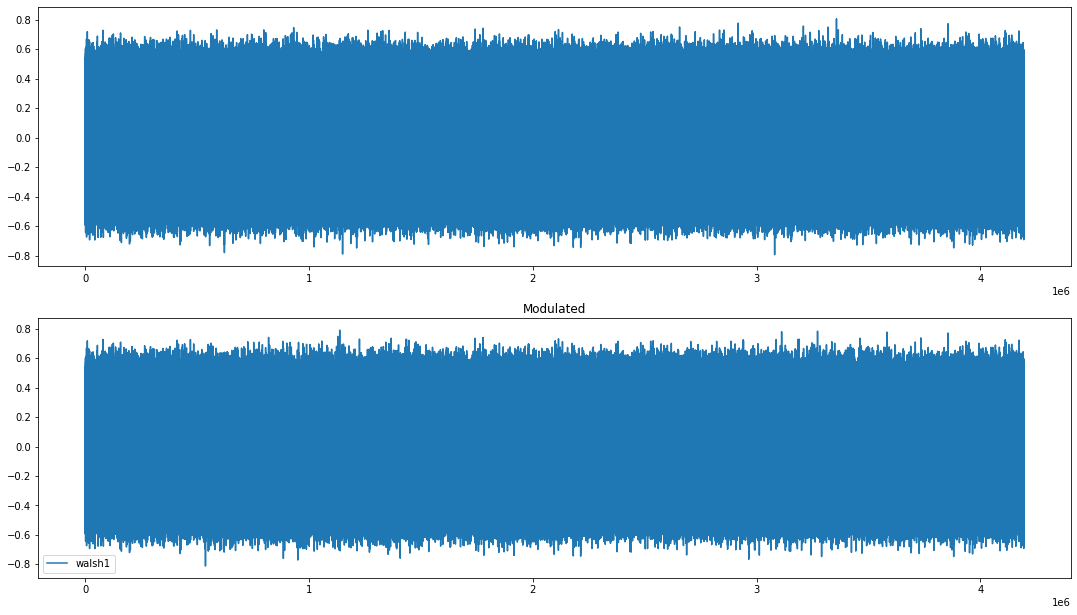

In [22]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].plot(demodulated0, label='walsh0')
ax[1].plot(demodulated1, label='walsh1')
#ax[i].set_xlim(0,10)
plt.title('Modulated')
plt.legend()
plt.show()

/home/jhub_admin/src/anaconda/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


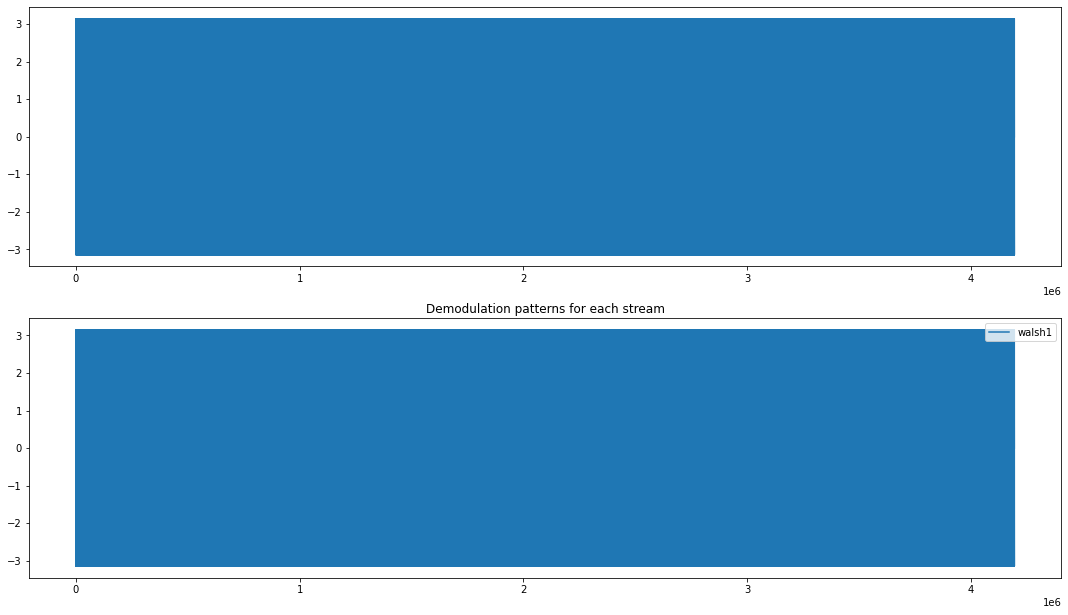

In [23]:
fig,ax = plt.subplots(2,1)
fig.set_size_inches(18.5, 10.5)
ax[0].plot(np.angle(demodulated0)-np.angle(data), label='walsh0')
ax[1].plot(np.angle(demodulated1)-np.angle(data), label='walsh1')
plt.title('Demodulation patterns for each stream')
plt.legend()
plt.show()

(1, 513)


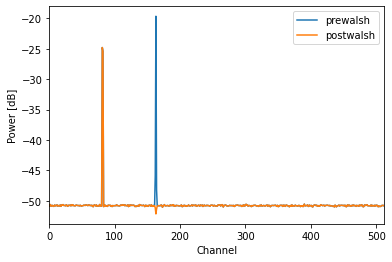

In [24]:
crossprewalsh = pfb_correlator(data + cw_signal, data + cw_signal, n_taps=M, n_chan=P, n_int=n_int, window_fn="blackmanharris")
crosswalsh = pfb_correlator(demodulated0, demodulated1, n_taps=M, n_chan=P, n_int=n_int, window_fn="blackmanharris")
print(crossprewalsh.shape)
plt.plot(db(np.abs(crossprewalsh[0])),  label='prewalsh')
plt.plot(db(np.abs(crosswalsh[0])),  label='postwalsh')

plt.xlim(0, P/2)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.legend()
plt.show()

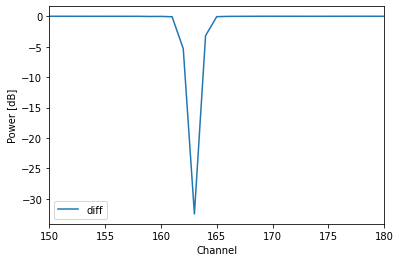

In [26]:
crossprewalsh = pfb_correlator(data + cw_signal, data + cw_signal, n_taps=M, n_chan=P, n_int=n_int, window_fn="blackmanharris")
crosswalsh = pfb_correlator(demodulated0, demodulated1, n_taps=M, n_chan=P, n_int=n_int, window_fn="blackmanharris")

plt.plot(db(crosswalsh[0])-db(crossprewalsh[0]),  label='diff')
#plt.xlim(0, P/2)
plt.xlim(150,180)
plt.xlabel("Channel")
plt.ylabel("Power [dB]")
plt.legend()
plt.show()